In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
from wordcloud import WordCloud
import plotly.graph_objects as go
import gdown
import zipfile
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
import nltk
nltk.download('stopwords')


# DataPrep
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# loading dates

In [ ]:
# Google Drive URL
zip_url = "https://drive.google.com/uc?id=1Jk5ANQ6noxdeJv73zhfxUym3lyuoVMq6"

# Function to download and read the zip archive containing CSV files
def download_and_read_csv_zip(zip_url):
    # Download the zip file from Google Drive
    output = 'archive.zip'
    gdown.download(zip_url, output, quiet=False)

    # Dictionary to store DataFrames
    dfs = {}

    # Open the zip file
    with zipfile.ZipFile(output, "r") as zip_ref:
        # Extract each CSV file from the zip archive
        for file_name in zip_ref.namelist():
            if file_name.endswith('.csv'):
                # Read the CSV file directly into a pandas DataFrame
                df = pd.read_csv(zip_ref.open(file_name), encoding='iso-8859-1')
                # Store the DataFrame in the dictionary
                dfs[file_name] = df

    return dfs

# Call the function with the zip URL
dfs = download_and_read_csv_zip(zip_url)

# View all DataFrames
for file_name, df in dfs.items():
    print("File:", file_name)
    print(df)
    print("="*50)


Downloading...
From (original): https://drive.google.com/uc?id=1Jk5ANQ6noxdeJv73zhfxUym3lyuoVMq6
From (redirected): https://drive.google.com/uc?id=1Jk5ANQ6noxdeJv73zhfxUym3lyuoVMq6&confirm=t&uuid=b86e0758-827c-46c2-8c90-7ea76845c6ca
To: /content/archive.zip
100%|██████████| 45.0M/45.0M [00:01<00:00, 26.9MB/s]


File: S_Data/__MACOSX/._customers.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._geolocation.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._order_items.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._order_payments.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._order_reviews.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._orders.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._product_category_name_translation.csv
  Unnamed: 0
0        o\t
File: S_Data/__MACOSX/._products.csv
   Unnamed: 0
0          21
File: S_Data/__MACOSX/._sellers.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/customers.csv
                            customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac

In [ ]:
file_name = 'S_Data/order_items.csv'

if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    order_items = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))


In [ ]:
file_name = 'S_Data/customers.csv'

if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    customer = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))


In [ ]:
file_name ='S_Data/orders.csv'
if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    orders = dfs[file_name]

else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))


In [ ]:

file_name ='S_Data/order_payments.csv'
if file_name in dfs:
    order_payments = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))


In [ ]:
file_name ='S_Data/order_reviews.csv'

if file_name in dfs:
    order_reviews = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))

order_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,ParabÃ©ns lojas lannister adorei comprar pela ...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rÃ¡pida. Supe...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [ ]:
file_name ='S_Data/sellers.csv'
if file_name in dfs:
    sellers = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))

In [ ]:

file_name ='S_Data/products.csv'
if file_name in dfs:

    products = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))


# Task 3. Analysis of product semantics
Our database contains information about numerical product ratings with text comments. I hear that modern algorithms can read and understand these reviews. Let’s implement the functionality for classifying positive/negative comments and consolidate the analytics. I’m interested in the correlation of text comments with a numerical rating (1-5), products with the best/worst reviews, sellers who only collect negative feedback.
I would also like to highlight such an entity as price in the comment text, so that the analytical department looks through this information for mentions of the competitors’ prices.



In [ ]:
df_comments = order_reviews.loc[:, ['order_id','review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['order_id', 'score', 'comment']
df_comments.head()

Dataset shape: (41753, 3)


,order_id,score,comment
0,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
1,8e6bfb81e283fa7e4f11123a3fb894f1,5,ParabÃ©ns lojas lannister adorei comprar pela ...
2,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...
3,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiÃ¡vel, produto ok e entrega ante..."


In [ ]:
def find_patterns(re_pattern, text_list):
    """
    Args:
    ---------
    re_pattern: regular expression pattern to be used on search [type: string]
    text_list: list with text strings [type: list]

    Returns:
    positions_dict: python dictionary with key-value pars as below:
        text_idx: [(start_pattern1, end_pattern1), (start_pattern1, end_pattern2), ... (start_n, end_n)]
    """

    # Compiling the Regular Expression passed as a arg
    p = re.compile(re_pattern)
    positions_dict = {}
    i = 0
    for c in text_list:
        match_list = []
        iterator = p.finditer(c)
        for match in iterator:
            match_list.append(match.span())
        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            pass
        else:
            positions_dict[control_key] = match_list
        i += 1

    """p = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    pattern_dict = find_patterns(p, reviews_breakline)
    print(len(pattern_dict))
    pattern_dict
    for idx in [int(c.split(' ')[-1]) for c in list(pattern_dict.keys())]:
        print(f'{reviews_breakline[idx]}\n')"""

    return positions_dict

def print_step_result(text_list_before, text_list_after, idx_list):
    """
    Args:
    ----------
    text_list_before: list object with text content before transformation [type: list]
    text_list_after: list object with text content after transformation [type: list]
    idx_list: list object with indexes to be printed [type: list]
    """

    # Iterating over string examples
    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        print(f'Before: \n{text_list_before[idx]}\n')
        print(f'After: \n{text_list_after[idx]}\n')
        i += 1

In [ ]:
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """

    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [ ]:
# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_step_result(reviews, reviews_breakline, idx_list=[48])

--- Text 1 ---

Before: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!
Tudo certo!

Att 

Elenice.

After: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!  Tudo certo!    Att     Elenice.



Sites and Hiperlinks


In [ ]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """

    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

# Verifying results
print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10796, 12782])

--- Text 1 ---

Before: 
comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto http://prntscr.com/jkx7hr quando o produto chegou aqui veio todos com a mesma cor, tabaco http://prntscr.com/

After: 
comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto  link  quando o produto chegou aqui veio todos com a mesma cor, tabaco  link 

--- Text 2 ---

Before: 
Pedi esse: https://www.lannister.com.br/produto/22880118/botox-capilar-selafix-argan-premium-doux-clair-2x1-litro?pfm_carac=doux%20clair&pfm_index=3&pfm_page=search&pfm_pos=grid&pfm_type=search_page%

After: 
Pedi esse:  link 



dates


In [ ]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """

    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

# Verifying results
print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[26665, 41497, 41674])

--- Text 1 ---

Before: 
(tenso) tinhas mais de 10 lojas pra min escolher qual comprar, o pitei pela lannister por ser uma loja conhecida a entrega estava para dia 22/01/2018 . hoje jÃ¡ Ã© 24/01/2018 pois comprei dia 06/01/18

After: 
(tenso) tinhas mais de 10 lojas pra min escolher qual comprar, o pitei pela lannister por ser uma loja conhecida a entrega estava para dia  data  . hoje jÃ¡ Ã©  data  pois comprei dia  data 

--- Text 2 ---

Before: 
COMPREI EM 21/03/2018, PG VIA CARTÃO EM 21/03/2018, NF FOI EMITIDA DIA 27/03/2018, PREVISÃO ENTREGA EM 12/04/2018, HOJE Ã 14/04/2018, NÃO RECEBI, NÃO ESTÃ EM TRANSPORTE, ESTOU MUITO PREOCUPADO

After: 
COMPREI EM  data , PG VIA CARTÃO EM  data , NF FOI EMITIDA DIA  data , PREVISÃO ENTREGA EM  data , HOJE Ã  data , NÃO RECEBI, NÃO ESTÃ EM TRANSPORTE, ESTOU MUITO PREOCUPADO

--- Text 3 ---

Before: 
JÃ¡ comprei vÃ¡rias vezes no site "lannister";mas  desta Ãºltima vez,fiz uma compra de um TONER no  04.10.16 e sÃ³ prometeram p/ 25.11.

Money


Another pattern that probably is very common on this kind of source is representations of money (R$ _,_). To improve our model, maybe it's a good idea to transform this pattern into a key word like valor (means money or amount in english).


In [ ]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """

    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Verifying results
print_step_result(reviews_dates, reviews_money, idx_list=[26020, 33297, 32998])

--- Text 1 ---

Before: 
Recebi o produto correto, porÃ©m o valor do produto na NF ficou a menor, R$ 172,00 sendo que comprei a 219,90.  O valor do frete calculado foi R$ 18,90 e veio R$ 93,00.  Gostaria que viesse com correto

After: 
Recebi o produto correto, porÃ©m o valor do produto na NF ficou a menor,  dinheiro  sendo que comprei a 219,90.  O valor do frete calculado foi  dinheiro  e veio  dinheiro .  Gostaria que viesse com correto

--- Text 2 ---

Before: 
Infelizmente, para uma entrega em GRU (RegiÃ£o Metropolitana da Grande SP) achei bem "salgado" o valor do frete cobrado sobre o preÃ§o do produto! Afinal, a mercadoria custou R$26,70 + R$15,11 de frete!

After: 
Infelizmente, para uma entrega em GRU (RegiÃ£o Metropolitana da Grande SP) achei bem "salgado" o valor do frete cobrado sobre o preÃ§o do produto! Afinal, a mercadoria custou  dinheiro  +  dinheiro  de frete!

--- Text 3 ---

Before: 
Paguei $48,00 reais de frete e acabei tendo que buscar o pedido no Centro de Distrib

In [ ]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """

    # Applying regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]
# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

# Verifying results
print_step_result(reviews_money, reviews_numbers, idx_list=[68])

--- Text 1 ---

Before: 
Comprei o produto dia 25 de fevereiro e hoje dia 29 de marco nÃ£o fora entregue na minha residÃªncia. NÃ£o sei se os correios desse Brasil e pÃ©ssimo ou foi a prÃ³pria loja que demorou postar.

After: 
Comprei o produto dia  numero  de fevereiro e hoje dia  numero  de marco nÃ£o fora entregue na minha residÃªncia. NÃ£o sei se os correios desse Brasil e pÃ©ssimo ou foi a prÃ³pria loja que demorou postar.



Negation
This session was thought and discussed in a special way. The problem statement is that when we remove the stopwords, probabily we would loose the meaning of some phrases about removing the negation words like não (not), for example. So, because of this, maybe is a good idea to replace some negation words with some common words indicating a negation meaning.

In [ ]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """

    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

# Verifying results
print_step_result(reviews_numbers, reviews_negation, idx_list=[4783, 4627, 4856, 4904])

--- Text 1 ---

Before: 
O material Ã© bom, o problema Ã© que a bolsa nÃ£o fecha, nÃ£o possui zÃ­per, Ã© como uma sacola. Isso me deixou insatisfeita, pois na foto nÃ£o dÃ¡ pra perceber e nÃ£o hÃ¡ informaÃ§Ã£o ou foto interna sobre isso.

After: 
O material Ã© bom, o problema Ã© que a bolsa nÃ£o fecha, nÃ£o possui zÃ­per, Ã© como uma sacola. Isso me deixou insatisfeita, pois na foto nÃ£o dÃ¡ pra perceber e nÃ£o hÃ¡ informaÃ§Ã£o ou foto interna sobre isso.

--- Text 2 ---

Before: 
Meu pedido era para ser entregue atÃ© dia  data , atÃ© a presente data ( numero / numero ) a nota fiscal nÃ£o foi emitida, solicitei vÃ¡rias vezes nÃ£o obtive retorno, nÃ£o recomendo esta Loja, nem a lannister!!!!!!

After: 
Meu pedido era para ser entregue atÃ© dia  data , atÃ© a presente data ( numero / numero ) a nota fiscal nÃ£o foi emitida, solicitei vÃ¡rias vezes nÃ£o obtive retorno, nÃ£o recomendo esta Loja, nem a lannister!!!!!!

--- Text 3 ---

Before: 
OEQUIPAMENTO NÃO FUNCIONA. O mini cartao SD na

Special Characters

In [ ]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """

    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[45, 135, 234])

--- Text 1 ---

Before: 
Este foi o pedido  Balde Com  numero  PeÃ§as - Blocos De Montar  numero  un -  dinheiro  cada (NÃO FOI ENTREGUE)  Vendido e entregue targaryen  Tapete de Eva NÂº Letras  numero  PeÃ§as CrianÃ§as  numero  un -  dinheiro  (ESTE FOI ENTREG

After: 
Este foi o pedido  Balde Com  numero  PeÃ as   Blocos De Montar  numero  un    dinheiro  cada  NÃ O FOI ENTREGUE   Vendido e entregue targaryen  Tapete de Eva NÂº Letras  numero  PeÃ as CrianÃ as  numero  un    dinheiro   ESTE FOI ENTREG

--- Text 2 ---

Before: 
Cada vez que compro mais fico satisfeita parabÃ©ns pela honestidade com seus clientes ðððð?

After: 
Cada vez que compro mais fico satisfeita parabÃ ns pela honestidade com seus clientes ð   ð   ð   ð    

--- Text 3 ---

Before: 
Comprei o produto, paguei no boleto e sÃ³ recebi metade do produto, anunciaram uma coisa Ã© mandaram outra. Muito insatisfeita ð¡ð¡ð¡

After: 
Comprei o produto  paguei no boleto e sÃ³ recebi metade do produto  anun

After all the steps we have taken over here, it's important to clean our text eliminating unecessary whitespaces. Let's apply a RegEx for this and see what we've got.

In [ ]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """

    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[3, 4, -1])

--- Text 1 ---

Before: 
Mas um pouco  travando   pelo valor ta Boa   

After: 
Mas um pouco travando pelo valor ta Boa

--- Text 2 ---

Before: 
Vendedor confiÃ vel  produto ok e entrega antes do prazo 

After: 
Vendedor confiÃ vel produto ok e entrega antes do prazo

--- Text 3 ---

Before: 
meu produto chegou e ja tenho que devolver  pois estÃ  com defeito   nÃ o segurar carga

After: 
meu produto chegou e ja tenho que devolver pois estÃ com defeito nÃ o segurar carga



Stopwords Well, by now we have a text dataset without any pattern that we threated with RegEx and also without punctuations. In other words, we have a half-clean text with a rich transformation applied.

So, we are ready to apply some advanced text transformations like stopwords removal, stemming and the TF-IDF matrix process. Let's start with portuguese stopwords.

In [ ]:
# Examples of some portuguese stopwords
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total portuguese stopwords in the nltk.corpous module: 207


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

In [ ]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """

    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]


In [ ]:
# Removing stopwords and looking at some examples
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[0, 45, 500])

--- Text 1 ---

Before: 
Recebi bem antes do prazo estipulado

After: 
recebi bem antes prazo estipulado

--- Text 2 ---

Before: 
Este foi o pedido Balde Com numero PeÃ as Blocos De Montar numero un dinheiro cada NÃ O FOI ENTREGUE Vendido e entregue targaryen Tapete de Eva NÂº Letras numero PeÃ as CrianÃ as numero un dinheiro ESTE FOI ENTREG

After: 
pedido balde numero peã blocos montar numero un dinheiro cada nã entregue vendido entregue targaryen tapete eva nâº letras numero peã crianã numero un dinheiro entreg

--- Text 3 ---

Before: 
O produto nÃ o Ã bom

After: 
produto nã ã bom



Stemming

In [ ]:
nltk.download('rslp')

# Defining a function to remove the stopwords and to lower the comments
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """

    return [stemmer.stem(c) for c in text.split()]
# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


--- Text 1 ---

Before: 
recebi bem antes prazo estipulado

After: 
receb bem ant praz estipul

--- Text 2 ---

Before: 
pedido balde numero peã blocos montar numero un dinheiro cada nã entregue vendido entregue targaryen tapete eva nâº letras numero peã crianã numero un dinheiro entreg

After: 
ped bald numer peã bloc mont numer un dinh cad nã entreg vend entreg targaryen tapet eva nâº letr numer peã crianã numer un dinh entreg

--- Text 3 ---

Before: 
produto chegou ja devolver pois estã defeito nã segurar carga

After: 
produt cheg ja devolv poi estã defeit nã segur carg



Feature Extraction

once we have passe through RegEx, stopwords removal and stemming application, to give more meaning for the text we are analysing, we can use approachs like Bag of Words, TF-IDF and Word2Vec. For make our analysis easier, let's define a function that receives a text and a vectorizer object and applies the feature extraction on the respective text.

In [ ]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    """
    Args
    ------------
    text: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """

    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names()

    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)

    return corpus_features, df_corpus_features

In [ ]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41753 entries, 0 to 41752
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   order_id           41753 non-null  object
 1   score              41753 non-null  int64 
 2   comment            41753 non-null  object
 3   re_breakline       41753 non-null  object
 4   re_hiperlinks      41753 non-null  object
 5   re_dates           41753 non-null  object
 6   re_money           41753 non-null  object
 7   re_numbers         41753 non-null  object
 8   re_negation        41753 non-null  object
 9   re_special_chars   41753 non-null  object
 10  re_whitespaces     41753 non-null  object
 11  stopwords_removed  41753 non-null  object
 12  stemming           41753 non-null  object
dtypes: int64(1), object(12)
memory usage: 4.1+ MB


In [ ]:
def label_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score <= 2:
        return 'negative'
    else:
        return 'neutral'

df_comments['sentiment'] = df_comments['score'].apply(label_sentiment)
df_comments = df_comments[df_comments['sentiment'] != 'neutral']  # Optionally remove neutral reviews


In [ ]:
final_text_column = 'stemming'  # or 'stopwords_removed'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_comments[final_text_column])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, df_comments['sentiment'], test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.87      0.88      0.87      2297
    positive       0.95      0.94      0.95      5321

    accuracy                           0.92      7618
   macro avg       0.91      0.91      0.91      7618
weighted avg       0.92      0.92      0.92      7618

Accuracy: 0.9234707272249935


Overall Performance: With an accuracy of 92.35%, the model is performing very well.     
Balanced Performance: Both precision and recall are high for both classes, indicating that the model is both accurate and comprehensive in its predictions.    

High F1-Score: The high F1-scores indicate that the model has a good balance between precision and recall.


In [ ]:
# Example: Compute correlation if applicable (e.g., using numerical features extracted from text)
from scipy.stats import pearsonr

df_comments.loc[:, 'word_count'] = df_comments[final_text_column].apply(lambda x: len(x.split()))
correlation, _ = pearsonr(df_comments['score'], df_comments['word_count'])
print(f'Correlation between score and word count: {correlation}')


Correlation between score and word count: -0.4066875672538873


The correlation between score and word count being -0.4067 suggests a moderate negative relationship, indicating that higher scores tend to have shorter comments, and lower scores tend to have longer comments. This is an interesting insight into the nature of your reviews.


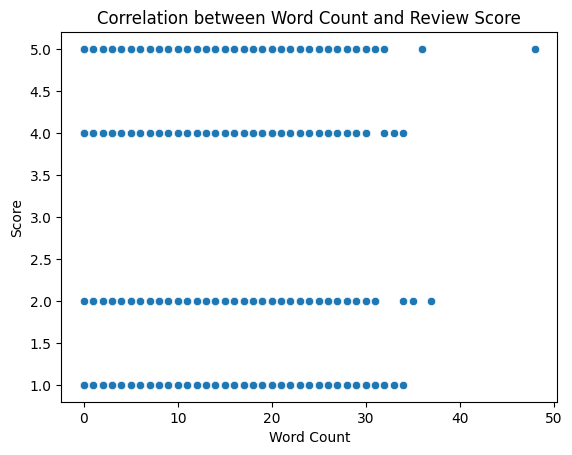

In [ ]:
sns.scatterplot(x='word_count', y='score', data=df_comments)
plt.title('Correlation between Word Count and Review Score')
plt.xlabel('Word Count')
plt.ylabel('Score')
plt.show()

In [ ]:
best_products = df_comments.groupby('order_id')['score'].mean().sort_values(ascending=False).head(10)
worst_products = df_comments.groupby('order_id')['score'].mean().sort_values().head(10)

negative_sellers = df_comments[df_comments['sentiment'] == 'negative'].groupby('order_id').size().sort_values(ascending=False).head(10)

print("Best Reviewed Products:\n", best_products)
print("Worst Reviewed Products:\n", worst_products)
print("Sellers with Most Negative Feedback:\n", negative_sellers)


Best Reviewed Products:
 order_id
00010242fe8c5a6d1ba2dd792cb16214    5.0
9450a19a745c16784964ea86003dc665    5.0
92c27ea1f64ba69eb0016fa7088034da    5.0
92c006b2d334e2c603a6569c2a4ce53f    5.0
92be217451e443e50d816ab21286d00d    5.0
92b8d0b30483bd64c2548331777e52a3    5.0
92b8ad8746bdc2d63f544dd75b17d7b3    5.0
92b678b4a340519864bc48f15ec27285    5.0
92b675d76f091290310bf9078366b8fb    5.0
92b48ee2f99d597171a30fc4a45e81ad    5.0
Name: score, dtype: float64
Worst Reviewed Products:
 order_id
a6a1840fec3ecb04c489ffa4b2354631    1.0
3817aebb6b2eab8cb6e13f3d2f163216    1.0
7b072cb297a1526bf0dcd28d61c6004d    1.0
7b068ded011750b422766fb0dbf020bb    1.0
3821374c4cfea859896f8a3d6f2b7a5a    1.0
3821dc9ac1b25bed42324d0885b0a930    1.0
7affac81820aaf2175139fb5e1f2b4c0    1.0
bcc4d7b9422f45610ec4008b5012e842    1.0
7afca88a125dd0c2b912bbf82c0496a4    1.0
e11ac0d86982b86bcde829263d5a38ec    1.0
Name: score, dtype: float64
Sellers with Most Negative Feedback:
 order_id
8e17072ec97ce29f0e1f111e598b

In [ ]:
import re

def extract_prices(text):
    prices = re.findall(r'dinheiro', text.lower())
    return prices

df_comments['price_mentions'] = df_comments['comment'].apply(extract_prices)
df_mentions_money = df_comments[df_comments['price_mentions'].apply(lambda x: len(x) > 0)]
df_mentions_money

,order_id,score,comment,re_breakline,re_hiperlinks,re_dates,re_money,re_numbers,re_negation,re_special_chars,re_whitespaces,stopwords_removed,stemming,word_count,sentiment,price_mentions
189,e30b9cda599826e24ad3f5eddf966583,1,NÃ£o foram entregue as duas capas de couro com...,NÃ£o foram entregue as duas capas de couro com...,NÃ£o foram entregue as duas capas de couro com...,NÃ£o foram entregue as duas capas de couro com...,NÃ£o foram entregue as duas capas de couro com...,NÃ£o foram entregue as duas capas de couro com...,NÃ£o foram entregue as duas capas de couro com...,NÃ o foram entregue as duas capas de couro com...,NÃ o foram entregue as duas capas de couro com...,nã entregue duas capas couro compradas apenas ...,nã entreg dua cap cour compr apen aguard devol...,14,negative,[dinheiro]
280,75a935207305c1dd6146a8012323cad9,1,"Gostaria de receber os produtos corretos, tent...","Gostaria de receber os produtos corretos, tent...","Gostaria de receber os produtos corretos, tent...","Gostaria de receber os produtos corretos, tent...","Gostaria de receber os produtos corretos, tent...","Gostaria de receber os produtos corretos, tent...","Gostaria de receber os produtos corretos, tent...",Gostaria de receber os produtos corretos tent...,Gostaria de receber os produtos corretos tente...,gostaria receber produtos corretos tentei real...,gost receb produt corret tent realiz troc devo...,16,negative,[dinheiro]
332,643e340c6c562d108526c36d5a94c027,1,"MEU PRODUTO AINDA NÃO FOI ENTREGUE, JÃ FIZ M...","MEU PRODUTO AINDA NÃO FOI ENTREGUE, JÃ FIZ M...","MEU PRODUTO AINDA NÃO FOI ENTREGUE, JÃ FIZ M...","MEU PRODUTO AINDA NÃO FOI ENTREGUE, JÃ FIZ M...","MEU PRODUTO AINDA NÃO FOI ENTREGUE, JÃ FIZ M...","MEU PRODUTO AINDA NÃO FOI ENTREGUE, JÃ FIZ M...","MEU PRODUTO AINDA NÃO FOI ENTREGUE, JÃ FIZ M...",MEU PRODUTO AINDA NÃ O FOI ENTREGUE JÃ FIZ M...,MEU PRODUTO AINDA NÃ O FOI ENTREGUE JÃ FIZ MIN...,produto ainda nã entregue jã fiz reclamaã ã at...,produt aind nã entreg jã fiz reclamaã ã atã ag...,21,negative,[dinheiro]
454,4d59391202a2a67c2e2fea6f349a67f5,5,Recebi o produto que eh falso quero meu dinhei...,Recebi o produto que eh falso quero meu dinhei...,Recebi o produto que eh falso quero meu dinhei...,Recebi o produto que eh falso quero meu dinhei...,Recebi o produto que eh falso quero meu dinhei...,Recebi o produto que eh falso quero meu dinhei...,Recebi o produto que eh falso quero meu dinhei...,Recebi o produto que eh falso quero meu dinhei...,Recebi o produto que eh falso quero meu dinhei...,recebi produto eh falso quero dinheiro volta,receb produt eh fals quer dinh volt,7,positive,[dinheiro]
648,09ae00385becd9090c7e85eb465605e0,1,"NÃ£o Ã© original, infelizmente o pÃ³s vendas d...","NÃ£o Ã© original, infelizmente o pÃ³s vendas d...","NÃ£o Ã© original, infelizmente o pÃ³s vendas d...","NÃ£o Ã© original, infelizmente o pÃ³s vendas d...","NÃ£o Ã© original, infelizmente o pÃ³s vendas d...","NÃ£o Ã© original, infelizmente o pÃ³s vendas d...","NÃ£o Ã© original, infelizmente o pÃ³s vendas d...",NÃ o Ã original infelizmente o pÃ³s vendas d...,NÃ o Ã original infelizmente o pÃ³s vendas da ...,nã ã original infelizmente pã³s vendas stark ã...,nã ã orig infeliz pã³ vend stark ã extrem ruim...,25,negative,[dinheiro]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41534,2b05d12915aef151cf97bb4e2a5ca58d,1,Estou tentando pegar meu dinheiro de volta des...,Estou tentando pegar meu dinheiro de volta des...,Estou tentando pegar meu dinheiro de volta des...,Estou tentando pegar meu dinheiro de volta des...,Estou tentando pegar meu dinheiro de volta des...,Estou tentando pegar meu dinheiro de volta des...,Estou tentando pegar meu dinheiro de volta des...,Estou tentando pegar meu dinheiro de volta des...,Estou tentando pegar meu dinheiro de volta des...,tentando pegar dinheiro volta desde novembro n...,tent peg dinh volt desd novembr numer ãºlt ped...,27,negative,[dinheiro]
41638,fddbd183387b5c9bcbafbd0fe965301f,1,SÃ³ quero meu

<ipython-input-138-30b967830b89>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='count', data=sentiment_counts, palette='viridis')


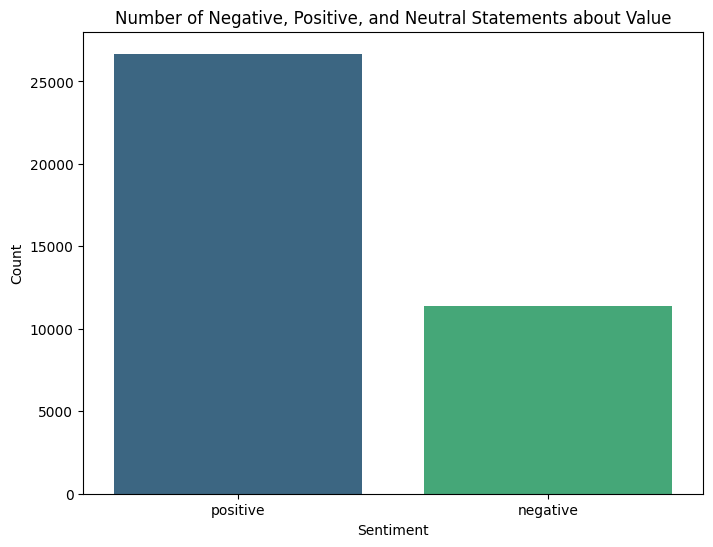

In [ ]:
df_comments['sentiment'] = df_comments['score'].apply(label_sentiment)

# Count the number of each sentiment
sentiment_counts = df_comments['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']

# Plot the graph
plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='count', data=sentiment_counts, palette='viridis')
plt.title('Number of Negative, Positive, and Neutral Statements about Value')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<ipython-input-139-d2706f441917>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='count', data=sentiment_counts_money, palette='viridis')


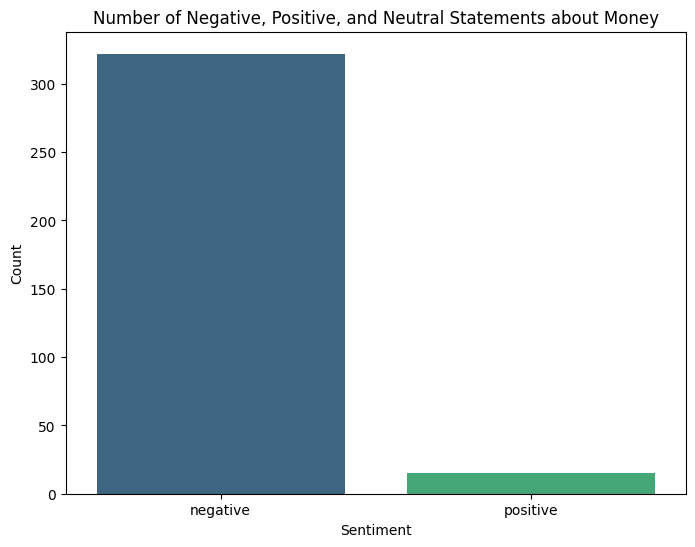

In [ ]:
sentiment_counts_money = df_mentions_money['sentiment'].value_counts().reset_index()
sentiment_counts_money.columns = ['sentiment', 'count']

# Plot the graph
plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='count', data=sentiment_counts_money, palette='viridis')
plt.title('Number of Negative, Positive, and Neutral Statements about Money')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
analytics = {
    'best_products': best_products,
    'worst_products': worst_products,
    'negative_sellers': negative_sellers,
    'price_mentions': df_comments[['order_id', 'price_mentions']][df_comments['price_mentions'].str.len() > 0]
}

with pd.ExcelWriter('analytics_report.xlsx') as writer:
    analytics['best_products'].to_excel(writer, sheet_name='Best Products')
    analytics['worst_products'].to_excel(writer, sheet_name='Worst Products')
    analytics['negative_sellers'].to_excel(writer, sheet_name='Negative Sellers')
    analytics['price_mentions'].to_excel(writer, sheet_name='Price Mentions')

That's it. Thanks